## 텍스트 생성 - 한글->영어 기계 번역

In [1]:
# 사용 모듈 import
import os
import pandas as pd
import numpy as np
from pprint import pprint

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, SimpleRNN, Input
from tensorflow.keras.utils import to_categorical

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [2]:
# 데이터 읽기
d_path = '../data/Chatbot_data-master/ChatbotData.csv'

In [3]:
# 데이터 읽기 및 확인
xlsx = pd.read_csv(d_path)
print(xlsx)

                             Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.             훔쳐보는 거 티나나봐요.      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11823 rows x 3 columns]


In [4]:
# 데이터 확인
print(xlsx['Q'])

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object


In [5]:
# 데이터 확인
print(xlsx['A'])

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object


In [6]:
# 사용할 데이터만 추출
kor_sentences = xlsx['Q'].values
print(len(kor_sentences))
pprint(kor_sentences[:5])
kor_sentences = kor_sentences[:100]

11823
array(['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다',
       'PPL 심하네'], dtype=object)


In [7]:
# 사용할 데이터만 추출
eng_sentences = xlsx['A'].values
print(len(eng_sentences))
pprint(eng_sentences[:5])
eng_sentences = eng_sentences[:100]

11823
array(['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.',
       '눈살이 찌푸려지죠.'], dtype=object)


In [8]:
# 한글 words_set 생성
kor_words_set = set()
kor_max_len = 0
for ix, sentence in enumerate(kor_sentences):
    words = [word.strip() for word in sentence.strip().split(' ')]

    if len(words) > kor_max_len:
        kor_max_len = len(words)
    while '' in words:
        words.remove('')
    kor_words_set.update(words)

In [9]:
# 한글 words_set 확인
kor_words_set = list(sorted(kor_words_set))
kor_words_set.insert(0, '')
print('#kor words: ', len(kor_words_set))
print('max seq length: ', kor_max_len)

#kor words:  238
max seq length:  8


In [10]:
# 영어 words_set 생성
eng_words_set = set()
eng_max_len = 0
for ix, sentence in enumerate(eng_sentences):
    words = [word.strip() for word in sentence.strip().split(' ')]
    if len(words) > eng_max_len:
        eng_max_len = len(words)
    while '' in words:
        words.remove('')
    eng_words_set.update(words)
eng_words_set.update(['<start>', '<eos>'])

In [11]:
# 영어 words_set 확인
eng_words_set = list(sorted(eng_words_set))
eng_words_set.insert(0, '')
print('#end words', len(eng_words_set))
print('max seq length: ', eng_max_len)

#end words 216
max seq length:  12


In [12]:
# 한국어 문장 정수 인코딩 및 패딩 함수 작성
def kor_encoding(sentence):
    words = [word.strip() for word in sentence.strip().split(' ')]
    while '' in words:
        words.remove('')

    words = [kor_words_set.index(word) for word in words]
    encode_sentence = words
    for _ in range(kor_max_len-len(encode_sentence)):
        encode_sentence.insert(0, 0)
    return np.asarray(encode_sentence).astype('float')

In [13]:
# 한국어 인코딩 및 데이터 확인
encode_sentences = []
for sentence in kor_sentences:
    encode_sentences.append(kor_encoding(sentence))
encode_sentences = np.asarray(encode_sentences).astype('float')
print(encode_sentences[:5])

[[  0.   0.   0.   0.   0.   0.   1. 117.]
 [  0.   0.   0.   0.   0.   2. 228. 119.]
 [  0.   0.   0.   0.   0.   3.  99. 170.]
 [  0.   0.   0.   0.   3. 207.  99. 170.]
 [  0.   0.   0.   0.   0.   0.   4. 169.]]


In [14]:
# 영어 문장 Special Symbol 포함 정수 인코딩 및 패딩
decode_sentences = []
for sentence in eng_sentences:
    words = [word.strip() for word in sentence.strip().split(' ')]
    while '' in words:
        words.remove('')
    
    words = [eng_words_set.index(word) for word in words]
    decode_sentence = words
    for _ in range(eng_max_len-len(decode_sentence)):
        decode_sentence.insert(0, 0)
    decode_sentence[0]=eng_words_set.index('<start>')
    decode_sentence.append(eng_words_set.index('<eos>'))
    decode_sentences.append(decode_sentence)
decode_sentences = np.asarray(decode_sentences).astype('float')

In [15]:
# 데이터 확인
print(decode_sentences[:5])

[[  3.   0.   0.   0.   0.   0.   0.   0.   0. 206.  67.   5.   2.]
 [  3.   0.   0.   0.   0.   0.   0.   0.   0.   0. 153.  58.   2.]
 [  3.   0.   0.   0.   0.   0.   0.   0.   0. 143. 141. 184.   2.]
 [  3.   0.   0.   0.   0.   0.   0.   0.   0. 143. 141. 184.   2.]
 [  3.   0.   0.   0.   0.   0.   0.   0.   0.   0.  41. 196.   2.]]


In [16]:
# 모든 데이터 One hot 인코딩
encoder_train = to_categorical(encode_sentences)
decoder_train = to_categorical(decode_sentences[:, :-1])
decoder_target = to_categorical(decode_sentences[:, 1:])

In [17]:
# 데이터 확인
print(encoder_train.shape)
print(decoder_target.shape)
print(decoder_train.shape)
print(encoder_train[:2])
print(decoder_train[:2])
print(decoder_target[:2])

(100, 8, 238)
(100, 12, 216)
(100, 12, 216)
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]


In [18]:
# Loss 저장을 위한 클래스 생성
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [19]:
# RNN cell 개수, 및 단어 개수 설정
num_units = 128
kor_num_token = len(kor_words_set)
eng_num_token = len(eng_words_set)

In [20]:
# 인코더 레이어 생성 및 연결
enc_inputs = Input(shape=(None, kor_num_token), name='encoder_input')
enc = SimpleRNN(num_units, return_sequences=True, return_state=True, name='encoder')
enc_outputs, enc_state = enc(enc_inputs)

In [21]:
# 디코더 레이어 생성 및 연결
dec_inputs = Input(shape=(None, eng_num_token), name='decoder_input')
dec = SimpleRNN(num_units, return_sequences=True, return_state=True, name='decoder')
dec_outputs, _ = dec(dec_inputs, initial_state=enc_state)
dec_dense = Dense(eng_num_token, activation='softmax', name='decoder_output')
dec_outputs = dec_dense(dec_outputs)

In [22]:
# 모델 생성
model = Model([enc_inputs, dec_inputs], dec_outputs)

In [23]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
# 모델 학습
model.fit([encoder_train, decoder_train], decoder_target, batch_size=8, epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 4ms/step - loss: 3.2885 - accuracy: 0.5492
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 2.3004 - accuracy: 0.6400
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 2.1801 - accuracy: 0.6625
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 2.0856 - accuracy: 0.6717
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 2.0636 - accuracy: 0.6700
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 1.9453 - accuracy: 0.6867
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 1.9341 - accuracy: 0.6842
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 1.8787 - accuracy: 0.6850
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 1.8255 - accuracy: 0.6883
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 1.7808 - accuracy: 0.6925
Epoch 11/

13/13 [==============================] - 0s 4ms/step - loss: 0.0831 - accuracy: 0.9942
Epoch 84/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0819 - accuracy: 0.9933
Epoch 85/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.9942
Epoch 86/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.9917
Epoch 87/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.9942
Epoch 88/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0608 - accuracy: 0.9975
Epoch 89/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9983
Epoch 90/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9908
Epoch 91/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.9967
Epoch 92/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0427 - accuracy: 1.0000
Epoch 93/100


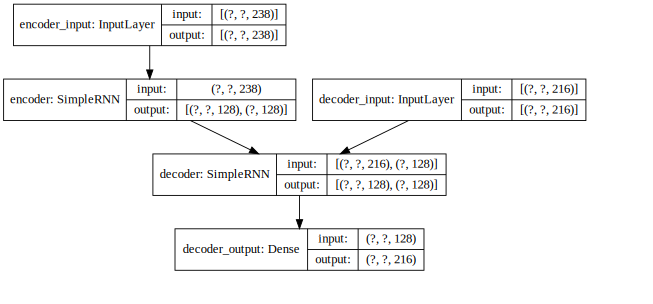

In [25]:
# 모델 확인
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))
## 이 모델에는 입력으로 항상 인코더 인풋과 디코더 인풋이 함께 들어가야 하기때문에 학습에만 
## 사용하며 실제 사용은 불가, 하지만 이미 학습은 진행되었기 때문에 weights는 학습 되었음.
## 따라서 학습된 레이어를 사용해 모델 재구성 필요.

In [26]:
# 인코더 모델 생성
encoder_model = Model(enc_inputs, enc_state)

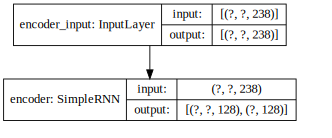

In [27]:
# 인코더 모델 시각화
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [28]:
# 디코더 모델 생성
decoder_state_input = Input(shape=(num_units,), name='decoder_state_input')
dec_outputs, dec_state = dec(dec_inputs, initial_state=decoder_state_input)
dec_outputs = dec_dense(dec_outputs)

decoder_model = Model(
    [dec_inputs] + [decoder_state_input],
    [dec_outputs] + [dec_state])

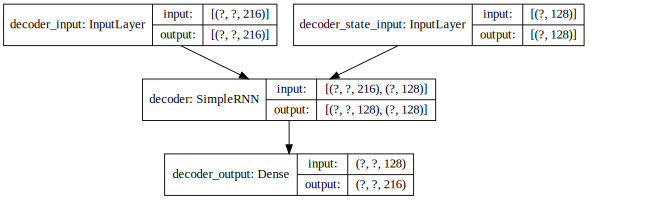

In [29]:
# 디코더 모델 시각화
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [30]:
# 모델로 한글을 영어로 번역하는 함수 작성
def decode_sequence(input_seq):
    state = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1, eng_num_token))
    target_seq[0, 0, eng_words_set.index('<start>')] = 1
    
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_token, state = decoder_model.predict([target_seq]+[state])
        
        sampled_token_index = np.argmax(output_token[0, -1, :])
        sampled_word = eng_words_set[sampled_token_index]
        if sampled_token_index != 0:
            decoded_sentence.append(sampled_word)
        
        if sampled_word == '<eos>':
            stop_condition = True
        
        target_seq = np.zeros((1, 1, eng_num_token))
        target_seq[0, 0, sampled_token_index] = 1
        
    return decoded_sentence[:-1]

In [31]:
# 이름만 translate
def translate(input_seq):
    decode_sequences = decode_sequence(input_seq)
    return decode_sequences

In [32]:
# 테스트용 인코더 입력 데이터 생성 및 확인
enc_sent = [kor_words_set[np.argmax(word_vec)] 
            for word_vec in encoder_train[0] if np.argmax(word_vec) != 0]
print(len(enc_sent))
print(enc_sent)

2
['12시', '땡!']


In [33]:
# 번역 및 결과 확인
sentence = translate(encoder_train[0].reshape(1, kor_max_len, -1))
print(len(sentence))
print(sentence)

3
['하루가', '또', '가네요.']


In [34]:
# 한글 -> 영어 결과 비교
print(' '.join(enc_sent))
print(' '.join(sentence))

12시 땡!
하루가 또 가네요.


In [35]:
print(len(kor_words_set))
print(kor_words_set)

238
['', '12시', '1지망', '3박4일', 'PPL', 'SD카드', 'SNS', 'SNS보면', '가기로', '가끔', '가끔은', '가난한', '가려고', '가만', '가상화폐', '가서', '가스불', '가스비', '가야지', '가자고', '가장', '가족', '가족관계', '가족끼리', '가족들', '가족들이랑', '가족여행', '가족이', '가족이랑', '가족한테', '가지?', '가출할까?', '가출해도', '간만에', '간식', '간장치킨', '간접흡연', '갈', '갈거야', '갈까', '감', '감기', '감기가', '감기약이', '감기인거', '감미로운', '감정이', '감정컨트롤을', '감정컨트롤이', '감히', '갑자기', '갔어', '강렬한', '강아지', '강원도', '같아', '같애', '같은', '같이', '개강룩', '개강옷', '개강이다', '개강이라니', '개같은', '개같이', '개기름', '개념도', '개념이', '개당황', '개당황했잖아', '개인적인', '개졸려', '개좋아', '개학하니까', '걔', '걔는', '걔랑', '거', '거지', '건', '걸리겠어', '걸린', '것', '게임하자고', '고고', '고민', '궁금해', '그런거니?', '기운이', '꼈어', '나', '나갔어', '나를', '나만', '나쁜', '나온거', '나왔다.', '남겨야', '너무', '놀러가고', '놀러갈', '놓고', '누구야?', '누굴', '눈물', '다', '닮아서', '당황했어', '데가', '돼', '됐으면', '되나?', '되버렸어.', '된', '들', '들더라', '땀난다', '땡!', '떨리니까', '떨어졌어', '막', '많이', '말까', '말까?', '말랭이', '망가졌어', '망함', '맞팔', '매일', '먹고', '먹어야지', '먹었는데', '먹을까', '목소리', '못하겠어', '무시하는', '물어', '물어봐서', '뭐', '뭐하는지', '뭘까?', '반', '보게됨', '보고', '

In [38]:
kor_sent = '나 누구야?'
enc_kor_sent = kor_encoding(kor_sent)
print(enc_kor_sent)

[  0.   0.   0.   0.   0.   0.  90. 102.]


In [39]:
sentence = translate(to_categorical(enc_kor_sent, num_classes=len(kor_words_set)).reshape(1, kor_max_len, -1))
print(len(sentence))
print(' '.join(sentence))

11
만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요
